In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

np.random.seed(0)

titanic_data  = pd.read_csv('https://raw.githubusercontent.com/pcsanwald/kaggle-titanic/master/train.csv')

titanic_data

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


<Axes: ylabel='Count'>

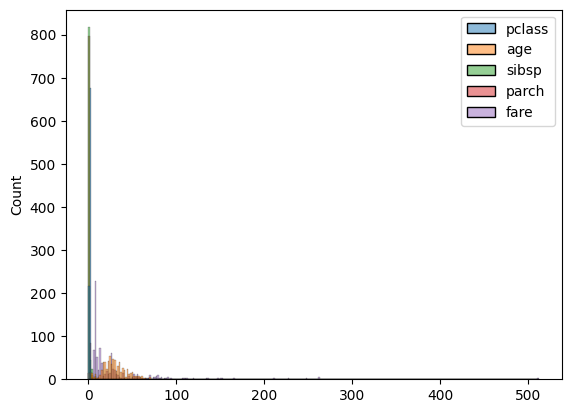

In [4]:
X = titanic_data.drop(['name','survived','ticket','cabin'], axis = 1)  # выбираем иксы

y = titanic_data.survived #выбираем игрик

sns.histplot(data = X)

In [ ]:
med = X.groupby('sex')['age'].transform('median')   #меняем пропуски возраста на средние в зависимости от пола
X = X.fillna({'age': med})


In [ ]:
X = pd.get_dummies(X)     #меняем строки на фэлстру
X = X.drop(['sex_female'], axis = 1)

In [ ]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [ ]:
max_depth_values = range(1,30)

scores_data = pd.DataFrame()

for max_depth in max_depth_values:      #подбираем вручную глубину дерева
  clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
  clf.fit(X_train, y_train)
  train_score = clf.score(X_train, y_train)
  test_score = clf.score(X_test, y_test)

  mean_cross = cross_val_score(clf, X_train, y_train, cv = 5).mean()

  temp_score_data = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': [test_score], 'cross_val_score': [mean_cross]})

  scores_data = pd.concat([scores_data, temp_score_data])

In [ ]:
scores_data_long = pd.melt(scores_data, id_vars = ['max_depth'], value_vars = ['train_score','test_score', 'cross_val_score'], var_name = 'set_type', value_name = 'score')

scores_data_long



,max_depth,set_type,score
0,1,train_score,0.788591
1,2,train_score,0.788591
2,3,train_score,0.825503
3,4,train_score,0.848993
4,5,train_score,0.854027
...,...,...,...
82,25,cross_val_score,0.776863
83,26,cross_val_score,0.778557
84,27,cross_val_score,0.785266
85,28,cross_val_score,0.780238


<Axes: xlabel='max_depth', ylabel='score'>

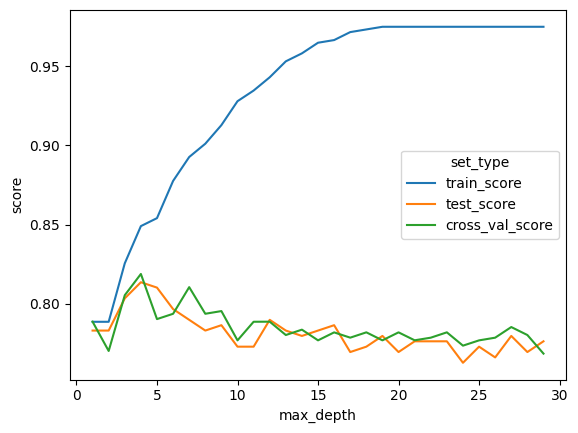

In [ ]:

sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

In [ ]:
from sklearn.model_selection import GridSearchCV
parametrs={'criterion':['gini', 'entropy'], 'max_depth': range(1, 30)}
clf=tree.DecisionTreeClassifier()

grid_search_cv_clf=GridSearchCV(clf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 4}

In [ ]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
best_clf.score(X_test, y_test)

0.8135593220338984

In [ ]:
y_pred = best_clf.predict(X_test)

In [ ]:
precision_score(y_test, y_pred)

0.7978723404255319

In [ ]:
recall_score(y_test, y_pred)

0.6756756756756757

In [ ]:
y_predicted_prob = best_clf.predict_proba(X_test)

<Axes: >

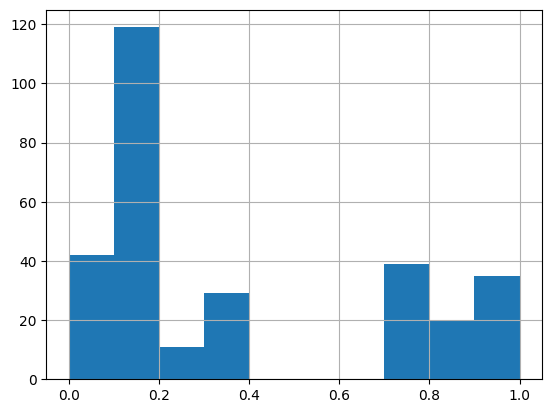

In [ ]:
pd.Series(y_predicted_prob[:,1]).hist()

In [ ]:
y_pred = np.where(y_predicted_prob[:,1] > 0.9, 1, 0)
precision_score(y_test, y_pred)

0.9714285714285714

In [ ]:
recall_score(y_test, y_pred)

0.3063063063063063

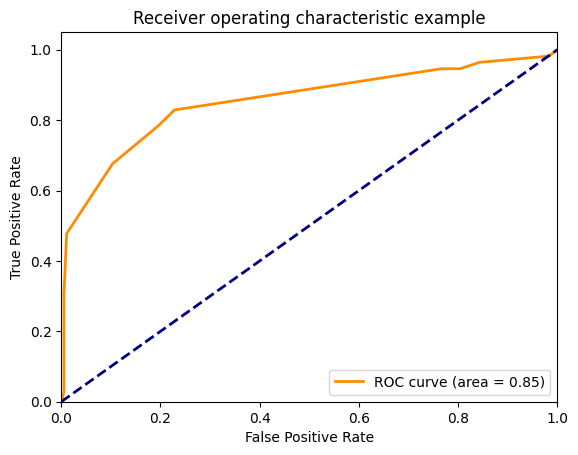

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])


roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

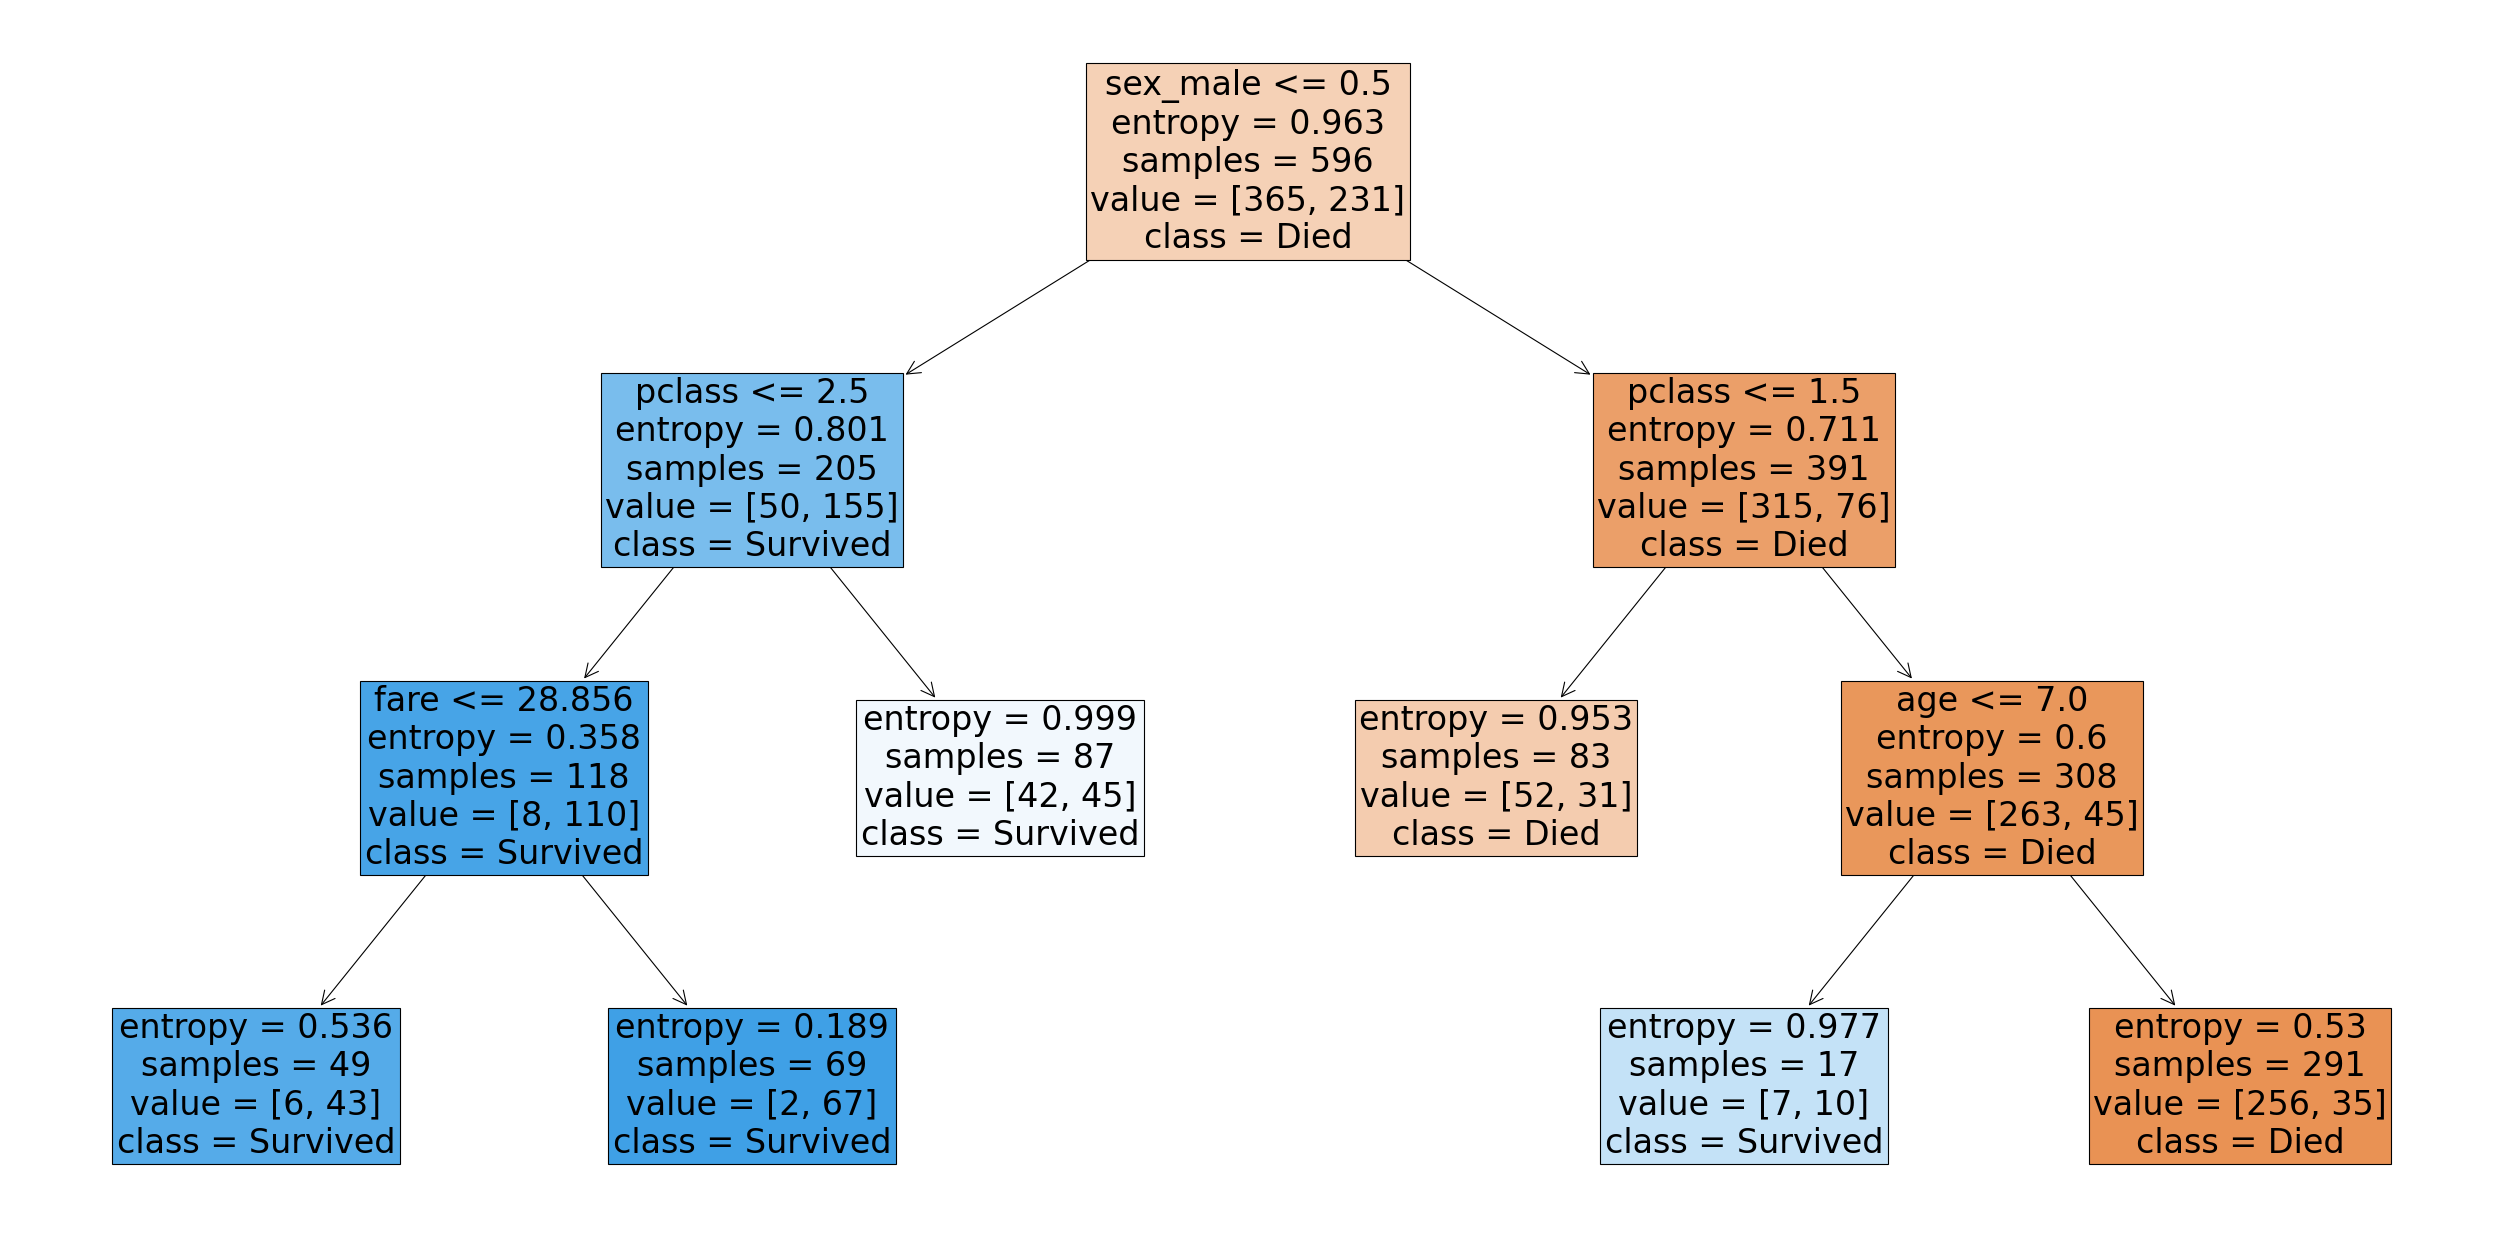

In [ ]:
clf=tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_split = 100, min_samples_leaf = 10)
clf.fit(X_train, y_train)
plt.figure(figsize=(40, 20),dpi=80)
p = tree.plot_tree(clf, fontsize=30,filled=True,feature_names=list(X),class_names = ['Died', 'Survived'])


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()
parametrs = {'n_estimators': [10,20,30], 'max_depth': [2,5,7,10]}
grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_

{'max_depth': 5, 'n_estimators': 30}